# Imports

todos:
    0) another nice idea for a matcher is to remove anomalies from the top 5 words. or to make a cluster for each class, and remove the results that are far. 
    1) no relation between merchant and local results in many cases. maybe use only place results?
    2) e-comerce - how to look for them?
    3) You can also make a names model - of course MART is Food, etc. ensembe it later. 

In [108]:
! pip install cleanco

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [109]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [110]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [111]:
import json
import pandas as pd
import multiprocessing as mp
from matplotlib import pyplot as plt
from typing import List
from functools import reduce
import numpy as np
from collections import Counter
from cleanco import basename
import regex
import nltk
from nltk.corpus import stopwords
from difflib import SequenceMatcher
from functools import partial
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import torch
from transformers import pipeline
from sklearn.model_selection import train_test_split
from datasets import Dataset
nltk.download('stopwords')
nltk.download('punkt')
plt.style.use('seaborn')
pool = mp.Pool(6)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [112]:
map_data_path = '/content/maps_data.json'
search_data_path = '/content/search_data.json'
labels_path = '/content/merchant_labels.csv'

# Utils

As we are dealing with unstructured data, we have to carefully examine the schema. 

This function will plot the percentage of data points that have a certain field:

In [113]:
def plot_keys_percentage(data:List[dict])->None:
    all_keys = list(reduce(lambda old,item: old.union(set(item.keys())),data,set()))
    counts_for_keys = [sum([1 if i[field] else 0 for i in data]) for field in all_keys]
    df = pd.DataFrame({'keys':all_keys,'counts':counts_for_keys}).sort_values('counts')
    plt.figure(figsize=(15, 5))
    plt.bar(df['keys'],df['counts'])
    plt.show()


In [114]:
def get_values_by_json_path(data:dict,path:List[str]) -> List[str]:
    """
    extract data from a dict using a list of keys
    """
    for key in path:
        data = data.get(key)
        if data is None:
            return
    return data

# Labels

In [115]:
labels = pd.read_csv(labels_path)

In [116]:
labels.head(3)

,merchant_name,category
0,PONNU SUPER MARKET,Other
1,Infinite 4,Entertainment
2,CHENNAI METRO RAIL LTD,Travel


Let's look at our labels distribution

Exception ignored in: <function SeekableUnicodeStreamReader.__del__ at 0x7fe2d3d039e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/nltk/data.py", line 1160, in __del__
    if not self.closed:
  File "/usr/local/lib/python3.7/dist-packages/nltk/data.py", line 1180, in closed
    return self.stream.closed
AttributeError: 'SeekableUnicodeStreamReader' object has no attribute 'stream'


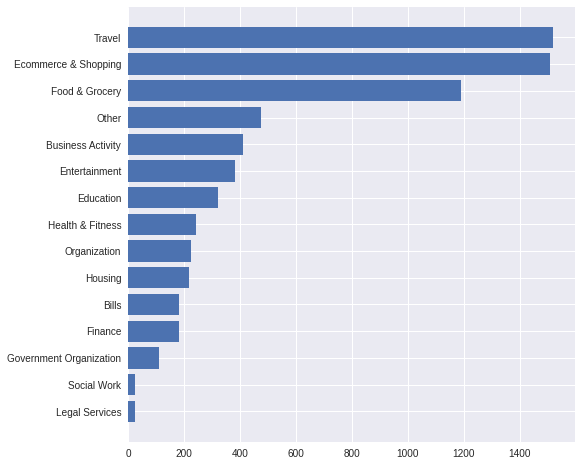

In [117]:
labels_counts = labels.value_counts('category',ascending=True)
plt.figure(figsize=(8,8))
plt.barh(labels_counts.index,labels_counts.values)
plt.show()

We can see that we have some classes that are extremly dominant, and some classes that are very rare. <br>
Usually in a business-oriented setting, we will decide which classes are more important and try to reach good results for them. <br>
Now, however, we will maximize our metrics overall, as we assume all classes are equally important. <br>

I am curious about the 'Other' Category. while watching the business names, it's clear that many of them are mislabeled.<br>
there are a lot of Marts, malls, and other businesses that clearly belong to the rest of the categories, Like Food % Grocecry. <br>
<b> We will drop merchant labeled as Other from our data, and send them for re-labeling</b>, as they may introduce noise.

In [118]:
labels = labels[labels['category'] != 'Other']

Also, let's look at other ambigious categories such as "Business activity" and Organization. 
We can see that both categories are very similiar, and contain a mix of businesses of many kinds - tech, communications, motors and so on.
We will label them both in the same way - Business.


In [119]:
print(labels[labels['category'].isin(['Organization','Business Activity'])].sample(20))
labels['category'] = labels['category'].map(lambda c: c.replace('Organization','Business'))
labels['category'] = labels['category'].map(lambda c: c.replace('Business Activity','Business'))

                                          merchant_name           category
6467                                  SRI ARAVINDAR AND  Business Activity
6398                                  Hamara Industries  Business Activity
3318                    MOBISKRIBE TECHNOLOGIES PVT LTD  Business Activity
3324                              DUNZO DIGITAL PRIVATE  Business Activity
1697                                  AUTOMOBILE CENTRE  Business Activity
5684                       Spun Technosoft services LLP       Organization
6912                     Global Nest Consulting Pvt Ltd       Organization
6273                                 DEEPAK AUTOMOBILES  Business Activity
4994                              GOOGLE *Canva Pty Ltd  Business Activity
3640                                        ADHOC KONDE  Business Activity
3301  ALL INDIA NETWORKING FACULTY ICONS PRIVATE LIM...       Organization
3292                                      SAPHIRE HONDA  Business Activity
5263            CHURCH OF

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Lets also take a look at Bills and see what is it about.
We can also see that Bills is a mixed category, made out of communication companies, gas and petrol companies, etc. We will also label them as Business.

**The main conclusion here is that the data in labeled quite poorly**,
probably based on some rule based classification. 
In a business setting, I would reccomend labeling the data again, to a more 
concise set of categories like "Communications", "Automotive" etc. 

In [120]:
print(labels[labels['category'].isin(['Bills'])].sample(20))
labels['category'] = labels['category'].map(lambda c: c.replace('Bills','Business'))

                           merchant_name category
6493                              DISHTV    Bills
5838                VIDEOCON D2H LIMITED    Bills
2305                    TATA SKY LIMITED    Bills
2558                              RELJIO    Bills
4987     KERALA WATER TAX-BILLDESKMUMBAI    Bills
4758              Gujarat Gas Company Li    Bills
2188          The Tata Power Company Ltd    Bills
757       Aavantika Gas Ltd Bill Payment    Bills
1683                           HR ENERGY    Bills
5417                    SHAHEED SURENDRA    Bills
6704                         Glow Energy    Bills
1382                   VODAFONE IDEA LTD    Bills
697               Jaipur Vidyut Vitran N    Bills
3061                            HMWSSBNE    Bills
6354  HPCL HIGRADE SERVICE CENTHYDERABAD    Bills
4948        D Vois SSV Broadband Pvt Ltd    Bills
1308                  Airtel Prepaid MUM    Bills
2451                 Airtel Postpaid MUM    Bills
1290                     VIDEOCOND2H LTD    Bills


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [121]:
labels['category'] = labels['category'].map(lambda c: c.replace('&','and'))

categories = list(labels['category'].unique())
categories

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


['Entertainment',
 'Travel',
 'Food and Grocery',
 'Housing',
 'Ecommerce and Shopping',
 'Business',
 'Health and Fitness',
 'Finance',
 'Education',
 'Government Business',
 'Social Work',
 'Legal Services']

# Search Data

## Load and parse data

In [122]:
with open(search_data_path,'r') as file:
    search_data = [json.loads(line) for line in file]

## Remove irelevant information

we can see that a lot of fields are irelevant, such as inline images.

In [123]:
search_data[0].keys()

dict_keys(['merchant_name', 'search_timestamp', 'search_information', 'ads', 'inline_images', 'inline_videos', 'top_stories_link', 'top_stories_serpapi_link', 'top_stories', 'related_questions', 'organic_results', 'related_search_boxes', 'related_searches', 'pagination', 'serpapi_pagination', 'knowledge_graph', 'twitter_results', 'local_map', 'local_results', 'answer_box', 'shopping_results', 'error', 'available_on', 'recipes_results', 'product_result', 'sports_results'])

let's remove them , and look at the relevant data

In [124]:
relevant_keys = ['merchant_name','organic_results','knowledge_graph']
def filter_keys(data_point:dict)->dict:
    return {k: v for k, v in data_point.items() if k in relevant_keys}

In [125]:
search_data = list(map(filter_keys,search_data))

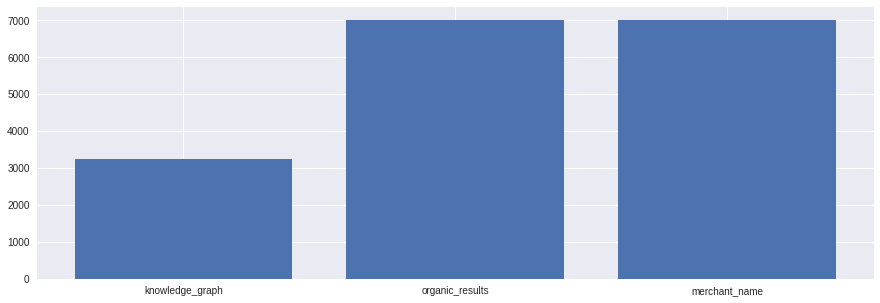

In [126]:
plot_keys_percentage(search_data)

## EDA

### Merchant Name

In [127]:
names = [data_point['merchant_name'] for data_point in search_data]
print(names[0:20])

['11 7 MART', '145 CAFE AND BAR', '1522', '19thOwl', '2001 D MART GHAZIABAD', '20dresses', '3101 D MART BHILWARA', '36 JUBILEE', '3922 D Mart Vapi', '3S SERVICE STATION', '3S Touch Service Soluti', '4052 D MART ANDHERI EAST MUMBAI', '4158 D Mart Nanded City', '4B Engineers', '4P Advisory Services Pvt Ltd', '4Pi Academy', '4tine', '5011 Dmart Kushaiguda', '51K Growth Hub', '5303 D MART GAJUWAKA V']


We can clearly see that the names are short strings, that may contain a lot of information! Look at all those "MART" bussiness..
But on the other hand, some merchant's names are ambigous, so it's obvious we'll have to use the search results content. Let's look at it.

### Organic Results

In [128]:
search_data[1]['organic_results'][0]

{'cached_page_link': 'http://webcache.googleusercontent.com/search?q=cache:hxpIJLpcwIgJ:145cafeandbar.com/+&cd=1&hl=en&ct=clnk&gl=in',
 'displayed_link': '145cafeandbar.com',
 'link': 'http://145cafeandbar.com/',
 'position': 1,
 'snippet': "Inspired by the city's eclectic choice in cuisines, 145 is a gastronomic homage to the spirit of Mumbai. We bring you a menu emulating all the local favourites but\xa0...",
 'thumbnail': None,
 'title': '145 Cafe and Bar'}

It seems like we have list of search results with their ranking. The Content is present mainly in the title and the snippet, but for some queries we get extra information.
for example here, in index 17, we can see we have a bottom section with questions and answers.and

In [129]:
search_data[17]['organic_results'][0]

{'cached_page_link': 'https://webcache.googleusercontent.com/search?q=cache:HmRMgiPyAYUJ:https://www.justdial.com/Hyderabad/D-Mart-in-ECIL/nct-11979574+&cd=1&hl=en&ct=clnk&gl=in',
 'displayed_link': 'www.justdial.com › Hyderabad › D Mart in Hyderabad',
 'link': 'https://www.justdial.com/Hyderabad/D-Mart-in-ECIL/nct-11979574',
 'missing': ['5011'],
 'must_include': {'link': 'https://www.google.co.in/search?hl=en&gl=in&q=%225011%22+dmart+kushaiguda&sa=X&ved=2ahUKEwithfuykK_pAhUzwzgGHfrLBygQ5t4CMAB6BAgFEBg',
  'word': '5011'},
 'position': 1,
 'rich_snippet': {'bottom': {'questions': ['Is there a cash on delivery option offered by DMart in Hyderabad?',
    'Does DMart sell non-vegetarian items online?',
    'What are the service timings of DMart in Hyderabad and is it open every day?',
    'What should I do if the product received is different from the one displayed on the site?',
    'What are the different modes of payment accepted at DMart?']},
  'top': {'detected_extensions': {'rating

We can see that not all merchants has query results at all! Lucky for us, we have the map data as well and we'll have to hope it will compenstate for that. 

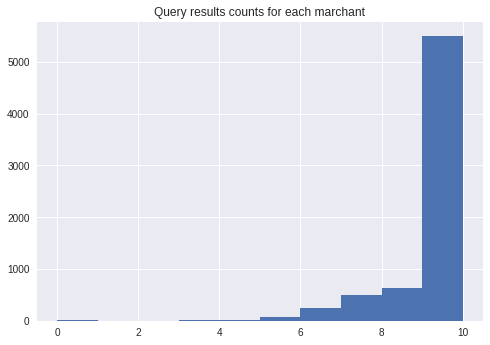

In [130]:
plt.hist(list(map(lambda data_point: len(data_point['organic_results']) if data_point['organic_results'] else 0 ,search_data)))
plt.title('Query results counts for each marchant')
plt.show()

### Knowledge Graph

The most interseting feature, as google does a lot of heavylifting work for us. Let's look at an example:

In [131]:
print(search_data[373]['knowledge_graph'].keys())
print('Look at this amazing feature:')
print(search_data[373]['knowledge_graph']['type'])
print(search_data[273]['knowledge_graph']['type'])


dict_keys(['title', 'type', 'website', 'local_map', 'address', 'raw_hours', 'hours', 'one_line_summary', 'people_also_search_for', 'people_also_search_for_link', 'people_also_search_for_stick'])
Look at this amazing feature:
Surgical supply store in Bengaluru, Karnataka
E-commerce service in New Delhi


It seems like Google classified example 273 for us as an E-Commerce store, in the type field!
alas, only some of the examples have a knowledge graph:

In [132]:
items_with_knowledge = list(filter(lambda item: item['knowledge_graph'],search_data))
percent_with_field = len(items_with_knowledge) / len(search_data)
print(f'Only {percent_with_field} of sample have this info')
items_with_type_field = list(filter(lambda item: item['knowledge_graph'].get('type'),items_with_knowledge))
percent_with_type = len(items_with_type_field) / len(search_data)
print(f'Only {percent_with_type} of sample have type')


Only 0.46114359047483244 of sample have this info
Only 0.3791530015685156 of sample have type


It would be amazing to use this feature, and we should definitly keep it in mind

## Conclusion

We can see there is a lot of content in the search results, with a lot of valuable information. 
Google gives us the amazing graph_knowledge, which contains processed information! 

The challange is to understand which search results is relevant to our specific merchant. We can deal with it in two ways -taking the top result(s), or making some kind of majority vote - if 80% of results that match our query are Travel merchants, It's likely our place is a Travel merchant as well. 

It's always smart to start simple, so at first try we'll just concatanate all the text of the merchant and see how our transformers we'll handle it :)
But afterwards it will be extremly useful to incorporate these features into our model as features of themselves, and not just another bunch of text. 

# Map Data

## parsing 

In [133]:
with open(map_data_path,'r') as file:
    map_data = [json.loads(line) for line in file]

## EDA

Lets look at the schema!
We can see we have two kinds of results, that aren't full - place results and query results.
Let's check out the error field before we'll filter it out:

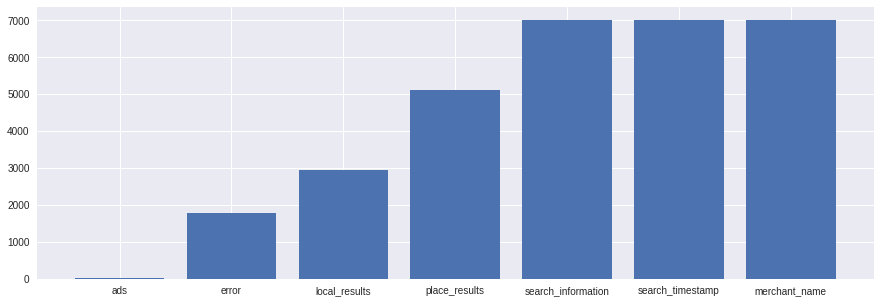

In [134]:
plot_keys_percentage(map_data)

In [135]:
data_with_errors = list(filter(lambda item: item['error'],map_data))
errors = set(map(lambda item: item['error'],data_with_errors))
errors

{"Google hasn't returned any results for this query."}

and we can see that data with errors has no results at all. <br>
Too bad, hope the search results for them is great!

In [136]:
errors_and_results_count = sum([1 if (i['place_results'] or i['local_results']) else 0 for i in data_with_errors])
print(f'there are {errors_and_results_count} merchants with errors and results!')

there are 0 merchants with errors and results!


Lets look at a place results example.<br>
We can see some interesting things:<br>
<list>
1) We have the amazing type field again, that will classifiy things for us.
2) Most of the text is contained inside the user reviews summary snippets, and in the description field of the most relevant user reviews
    </list>

In [137]:
#open cell in order to look
map_data[8]['place_results']

{'address': 'DMart Vapi,Chanod, Silvassa - Vapi Rd, Sulpad, Chanod Colony, Chanod, Gujarat 396191, India',
 'data_id': '0x3be0ce6971b00001:0xa0acce9ce50044f6',
 'extensions': [{'accessibility': ['Wheelchair accessible entrance']},
  {'payments': ['NFC mobile payments']}],
 'gps_coordinates': {'latitude': 20.3531381, 'longitude': 72.929308},
 'hours': [{'wednesday': '10am–10pm'},
  {'thursday': '10am–10pm'},
  {'friday': '10am–10pm'},
  {'saturday': '10am–10pm'},
  {'sunday': '10am–10pm'},
  {'monday': '10am–10pm'},
  {'tuesday': '10am–10pm'}],
 'place_id_search': 'https://serpapi.com/search.json?data=%214m5%213m4%211s0x3be0ce6971b00001%3A0xa0acce9ce50044f6%218m2%213d20.3531381%214d72.92930799999999&engine=google_maps&google_domain=google.co.in&hl=en&type=place',
 'rating': 4.2,
 'reviews': 1498,
 'thumbnail': 'https://lh5.googleusercontent.com/p/AF1QipNHHxkbIEg9WarSHagdiW-Nfdija45vItpq2Es2=w152-h86-k-no',
 'title': 'DMart Vapi,Chanod',
 'type': ['Supermarket'],
 'user_reviews': {'most_

Now let's look at some local results example.<br>
Initial Conclusions:<list>
1) We can see that the results here are less detailed. we sometimes get nice information in the description field, but it's not always there.
2) There is a big issue of matching results. it seems like many results don't fit what you are looking for. We will have to be carefull about it. 
3) we still have the type field, but it seems like we need to be carefull using it only when we are certain the place match our merchant.
4) We will not use search data for Ecommerce merchants as they dont have a physical address!
    </list>

# Solution Design


It seems like we have a lot of relevant information that contains a clear signal. <br>
The main challenge is not knowing how to match search results to the merchant.<br>
matching incorrectly will result in introducing misleading data, which will probably hurt performance.<br>
There are 2 strategies we can try:<list>
1) Averaging - We can take the top-k results, combine the data smartly, and feeding it to our model, hoping the law of big numbers will help us.
2) Matching titles - making a model that will predict a match between merchant name and the title of the query result, and only looking at data of matched objects. </list>

Matching is a smarter strategy, but we don't have data of correct matches, making it hard to evaluate our matcher. <br>

My initial startegy is to build a very simple matcher that will select the top2 results that have a very easy restrains on title matching.<br>
Then we will average out the top 2 results and see where does that brings us. <br>

I also want to keep in mind that "place results" in the map data seems to recognize and classify the merchant amazingly, and we have this data for most of the merchants.<br>
I think we can be creative here, and try another idea to test againt our main classifier.

# Dataset buildup

## Matcher

This matcher decides whether two business titles are matching or not. <br>
it filters the top k results that the merchant names are in their title.

In [138]:
class Matcher:
    def __init__(self,ratio_threshold:float,rank_threshold:int):
        self.threshold = ratio_threshold
        self.rank_threshold = int(rank_threshold)
   
    def match_titles(self,original_title:str,tested_title:str) -> bool:
        parsed_original = set(self.parse_merchant_name(original_title))
        parsed_tested = set(self.parse_merchant_name(tested_title))
        ratio_of_inclusion = len(parsed_original.intersection(parsed_tested))/len(parsed_original)
        return  ratio_of_inclusion >= self.threshold
    def match_top_k_results(self,rank:int)->bool:
        return rank < self.rank_threshold
    @staticmethod
    def parse_merchant_name(name:str) -> str:       
        new_name = basename(name) #cleanco cleans LTD  and such
        new_name = regex.sub(r"[[:punct:]]+", " ", new_name) # remove punctuation
        tokens = nltk.word_tokenize(new_name) 
        tokens = [t.lower() for t in tokens]
        tokens = [t for t in tokens if t not in stopwords.words('english')] #remove stop words
        return tokens if len(tokens)>=1 else [t.lower() for t in nltk.word_tokenize(name)]

## Text Extractor

This text extractor will extract all the text from both sources and index it by merchant.<br>
It will use a Matcher to decide which query results to considerate. 

In [139]:
class TextExtractor:
    def __init__(self,matcher:Matcher):
        self.matcher:Matcher = matcher
    
    def extract_text(self,merchant_name:str,search_data:List[dict],map_data:List[dict])->List[str]:
        search_results = list(filter(lambda data: data['merchant_name'] == merchant_name,search_data))[0]
        map_results = list(filter(lambda data: data['merchant_name'] == merchant_name,map_data))[0]
        text = []
        text += self.extract_text_from_searches(merchant_name,search_results)
        text += self.extract_text_from_map_results(merchant_name,map_results)
        text = list(filter(lambda t: t is not None,text))
        return text
    
    def extract_text_from_searches(self,merchant_name:str,search_results:dict)->List[str]:
        extracted_text = []
        extracted_text += self._extract_text_from_organic_results(merchant_name,search_results['organic_results'])
        knowledge_graph = search_results.get('knowledge_graph')
        if knowledge_graph:
            extracted_text += self._extract_text_from_knowledge_graph(knowledge_graph)
        return extracted_text
    
    def _extract_text_from_organic_results(self,merchant_name:str,organic_results:List[dict]) -> List[str]:
        if organic_results is None:
            return []
        text = []
        organic_results_with_title = filter(lambda result: result.get('title') is not None,organic_results)
        title_filtered = list(filter(lambda result: self.matcher.match_titles(merchant_name,result.get('title')),organic_results_with_title))
        filtered_results =  title_filtered[:self.matcher.rank_threshold+1]
        for result in filtered_results:
            text.append(result.get('snippet'))
            question_results = get_values_by_json_path(result,['rich_snippet','bottom','questions'])
            if question_results:
                text += question_results 
        return text
    
    def _extract_text_from_knowledge_graph(self,knowledge_graph:dict) -> List[str]:
        extracted_text = []
        extracted_text.append(knowledge_graph.get('type'))
        user_reviews = knowledge_graph.get('user_reviews')
        if isinstance(user_reviews,list):
            extracted_text += list(map(lambda review: review.get('summary'),user_reviews))
        
        return extracted_text
    
        
    def extract_text_from_map_results(self,merchant_name:str,map_results:dict)->List[str]:
        extracted_text = []
        place_results = map_results.get('place_results')
        local_results = map_results.get('local_results')
        if place_results:
            extracted_text += self._extract_text_from_place_results(merchant_name,map_results['place_results'])
        if local_results:
            extracted_text += self._extract_text_from_local_results(merchant_name,map_results['local_results'])
        #if E commerce tend to have no data, give them a "no data" sentence.
        return extracted_text
    
    def _extract_text_from_place_results(self,merchant_name:str,place_results:dict)->List[str]:
        text = []
        if not self.matcher.match_titles(merchant_name,place_results.get('title')):
            return []
        title = place_results.get('title')
        if title is not None:
            text += [title]
        if len(list(filter(lambda t: isinstance(t,float),text))) > 0:
            print('x')
        description = place_results.get('description')
        if description is not None:
            if isinstance(description,dict):
                text += [description.get('snippet')]
            else:
                text += [description]
        if len(list(filter(lambda t: isinstance(t,float),text))) > 0:
            print('y')
        type_field = place_results.get('type')
        if type_field is not None:
            text += type_field
        if len(list(filter(lambda t: isinstance(t,float),text))) > 0:
            print('z')
        text += self._get_text_from_user_reviews(place_results)
        if len(list(filter(lambda t: isinstance(t,float),text))) > 0:
            print('a')
        
        return text
        
    def _get_text_from_user_reviews(self,place_results:dict) -> List[str]:
        text = []
        if not place_results.get('user_reviews'):
            return []
        summaries = get_values_by_json_path(place_results,['user_reviews','summary'])
        if isinstance(summaries,list):
            text += map(lambda s: s.get('snippet'),summaries)
        most_relevant = get_values_by_json_path(place_results,['user_reviews','most_relevant'])
        if isinstance(most_relevant,list):
            text += map(lambda m: m.get('description'),most_relevant)
        return text
    
    def _extract_text_from_local_results(self,merchant_name:str,local_results:dict) -> List[str]:
        #Becuase local_results seems to give a lot of incorrect results, and place results has a lot of text, for the time being
        #I will leave it empty
        return []
                                                                    
    

## Dataset building

In [140]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.label = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.label[idx])
        return item

    def __len__(self):
        return len(self.label)


class DatasetBuilder:
    def __init__(self,text_extractor:TextExtractor,tokenizer=None):
        self.text_extractor = text_extractor
        if tokenizer:
          self.tokenizer = tokenizer

    
    def get_dataset_for_zero_shot(self,labels:pd.DataFrame,search_data:List[dict],map_data:List[dict]) ->  pd.DataFrame:
        text_df = self._extract_text(labels,search_data,map_data)
        X_train,X_val,X_test,y_train,y_val,y_test = self._split_data(text_df)
        return X_train,X_val,X_test,y_train,y_val,y_test

    
    def get_dataset_for_fine_tune(self,labels:pd.DataFrame,search_data:List[dict],map_data:List[dict]):
        text_df = self._extract_text(labels,search_data,map_data)
        text_df = self._explode_texts(text_df)
        text_df['category'] = text_df['category'].map(lambda category:categories.index(category))
        X_train,X_val,X_test,y_train,y_val,y_test = self._split_data(text_df)

        train_dataset = Dataset.from_dict({'text':X_train,'label':y_train})
        val_dataset = Dataset.from_dict({'text':X_val,'label':y_val})
        test_dataset = Dataset.from_dict({'text':X_test,'label':y_test})

        train_dataset = train_dataset.map(lambda x: self.tokenizer(x['text'],padding='max_length',truncation=True),batched=True)
        val_dataset = val_dataset.map(lambda x: self.tokenizer(x['text'],padding='max_length',truncation=True),batched=True)
        test_dataset = test_dataset.map(lambda x: self.tokenizer(x['text'],padding='max_length',truncation=True),batched=True)




        return (train_dataset,val_dataset,test_dataset)
    def get_dataset_for_feature_extraction(self,labels:pd.DataFrame,search_data:List[dict],map_data:List[dict]):
        text_df = self._extract_text(labels,search_data,map_data)
        text_df = self._explode_texts(text_df)
        text_df['category'] = text_df['category'].map(lambda category:categories.index(category))
        X_train,X_val,X_test,y_train,y_val,y_test = self._split_data(text_df)
        return X_train,X_val,X_test,y_train,y_val,y_test
    
    def get_datasets(self,labels:pd.DataFrame,search_data:List[dict],map_data:List[dict])->pd.DataFrame:
        text_df = self._extract_text(labels,search_data,map_data)
        text_df = self._explode_texts(text_df)
        text_df['category'] = text_df['category'].map(lambda category:categories.index(category))
        X_train,X_val,X_test,y_train,y_val,y_test = self._split_data(text_df)
        
        encoding_train = self.tokenizer(list(X_train['text']),truncation=True, padding=True)
        encoding_val = self.tokenizer(list(X_val['text']),truncation=True, padding=True)
        encoding_test = self.tokenizer(list(X_test['text']),truncation=True, padding=True)
        
        
        
        train_dataset = TextDataset(encoding_train, y_train)
        val_dataset = TextDataset(encoding_val, y_val)
        test_dataset = TextDataset(encoding_test, y_test)
        
        return train_dataset,val_dataset,test_dataset

    def get_dataset_of_names(self,labels):
      text_df = labels.copy()
      text_df['category'] = text_df['category'].map(lambda category:categories.index(category))
      text_df['names'] = text_df['merchant_name'].map(nltk.word_tokenize)
      text_df = text_df.explode('names')
      X_train,X_test,y_train,y_test = train_test_split(text_df['names'],text_df['category'],test_size=0.3)
      return X_train,X_test,y_train,y_test

    def _extract_text(self,labels:pd.DataFrame,search_data:List[dict],map_data:List[dict]) -> pd.DataFrame:
        extract_text = partial(self.text_extractor.extract_text,search_data=search_data,map_data = map_data)
        labels['text'] = labels['merchant_name'].map(extract_text)
        return labels
    def _explode_texts(self,texts_df:pd.DataFrame) -> pd.DataFrame:
        exploded_df = texts_df.explode('text')
        exploded_df = exploded_df[~exploded_df['text'].isin([None])]
        exploded_df = exploded_df.dropna(axis=0,how='any')
        return exploded_df
    def _split_data(self,text_df:pd.DataFrame):
        print(text_df.columns)
        X_train,X_test,y_train,y_test = train_test_split(text_df['text'],text_df['category'],test_size=0.2)
        X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2)
        return X_train,X_val,X_test,y_train,y_val,y_test
    
    def _vectorize_text(self,text_df:pd.DataFrame) -> pd.DataFrame:
        def preprocess_text(sentence:str):
            return tokenizer(sentence, truncation=True,padding=True,fast=True)
        
        text_df['text'] = text_df['text'].map(preprocess_text)
        return text_df
    def _preprocess_text(self,sentence:str):
        return tokenizer(sentence, truncation=True)

# Text Classification by Fine Tuning a Transformer

We have built a Text Extractor that extracts Google search and map text, matching with a matcher.
Our strategy is simple - train a model that learn to classifiy a sentence to the target categories.
We will do it by fine tuning a bert transformer.

In order to classify a merchant to the category, we will classify each of his sentences to a category. Than, the merchant will get the category which most of his sentences got. 

Let's see how far we can get with this method.

In [141]:
global_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
dataset_builder = DatasetBuilder(TextExtractor(Matcher(0.5,3)),tokenizer=global_tokenizer)
data_collator = DataCollatorWithPadding(tokenizer=global_tokenizer)
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(categories))

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.20.1",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10

In [142]:
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [143]:
dataset_builder = DatasetBuilder(TextExtractor(Matcher(0.5,3)),tokenizer=global_tokenizer)
train_dataset,val_dataset,test_dataset = dataset_builder.get_dataset_for_fine_tune(labels,search_data,map_data)

Index(['merchant_name', 'category', 'text'], dtype='object')


  0%|          | 0/48 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

In [144]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):

    logits, labels = eval_pred

    predictions = np.argmax(logits, axis=-1)

    return metric.compute(predictions=predictions, references=labels)

In [145]:
training_args = TrainingArguments(

    output_dir="./results",

    learning_rate=2e-5,

    per_device_train_batch_size=16,

    per_device_eval_batch_size=16,

    num_train_epochs=5,

    weight_decay=0.01,

)

trainer = Trainer(

    model=model,

    args=training_args,

    train_dataset=train_dataset,

    eval_dataset=val_dataset,

    tokenizer=global_tokenizer,

    data_collator=data_collator,

)

# trainer.train() # we can load the trained model file instead
model.load_state_dict(torch.load('/content/pytorch_model.bin'))
model.eval() #comment out if training

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

We have trained our model! that was a long one... 
Let's evaluate it on the test set

In [ ]:
tokenized_vectors = list(map(lambda t: global_tokenizer.encode(t,
                                      truncation=True,
                                      padding=True,
                                      return_tensors="pt"), test_dataset['text']))
test_predictions = []
for instance in tokenized_vectors:
  test_predictions.append(model(instance.to(0))[0].argmax().item())

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(test_predictions,test_dataset['label']))

## Text model performance

it seems like our performance is OK. THIS IS NOT SUPRISING!
Many of the texts are irrelevant to their category! so I've expected the performance to be low or medium at most.

We need of course to look at the weighted average, as we have class imbalance.
0.73 f1 score is not good but not too bad.

**The interesting question is how good this model can be when predicting merchant, as each merchant has a lot of texts attache to it!**

## Merchant classifier based on bert

Let's get a dataset ready for us. each merchant will have all of his extracted texts attached to it. 
Than, we will give each merchant a prediction based on the count of categories his sentences are classified into. 

In [ ]:
 X_text_train,X_text_val,X_text_test,y_text_train,y_text_val,y_text_test = dataset_builder.get_dataset_for_zero_shot(labels,search_data,map_data)

In [ ]:
class MerchantClassifier:
  def __init__(self,model):
    self.model = model
  def predict(self,texts:pd.Series) -> List[int]:
    tokenized_texts = texts.map(lambda texts_list: list(map(lambda text:global_tokenizer.encode(text,
                                      truncation=True,
                                      padding=True,
                                      return_tensors="pt"),texts_list)))
    without_empty_texts = tokenized_texts[tokenized_texts.map(lambda x: x!= [])]
    preds = without_empty_texts.map(lambda texts_list: list(map(lambda t:self.model(t.to(0))[0].argmax().item(),texts_list)))
    prediction = preds.map(lambda preds: max(preds,key=preds.count))
    return prediction
  def predict_with_xgboost(self,texts:List[str]) -> List[int]:
    prediction = []
    for t in texts:
        filtered_t = list(filter(lambda text: True if (text != None and text != []) else False,t))
        if filtered_t == []:
            prediction.append(np.array([4]))
        else:
            single_pred = []
            for string in filtered_t:
                single_pred.append(self.model.predict([string]))
            prediction.append(max(single_pred,key=single_pred.count))
        
    return prediction


In [ ]:
l = [1,10,200]
list(filter(lambda x: x< 10,l))

In [ ]:
m = MerchantClassifier(model)
prediction = m.predict(X_text_test)
print(classification_report(prediction,y_text_test[prediction.index].map(lambda x: categories.index(x))))

## Merchant Classifier Results

WOW !!! Amazing! 
a 0.92 weighted f1 score! With all this junk text attached.

Transformers are indeed incredible. Look at how robust they are, that even though we classified our text model on a lot of junk data, the performance are really great. that's amazing. 

Basically we can say we finished, but I want to look at some more solutions. 

# XGBoost classifier

We will now look at a much simpler model to train - an XGboost model trained on TF-IDF vectors of the words. Let's see how it will fare. 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from xgboost import XGBClassifier


text_xgboost_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', XGBClassifier())],verbose=True)

parameters = {
    'clf__scale_pos_weight':[1],
    'clf__lambda': [1],
    'clf__max_depth': [6],
    'clf__eta': [0.3]

}

cv_xgboost = GridSearchCV(text_xgboost_clf,parameters,cv=2)

In [ ]:
X_train,X_val,X_test,y_train,y_val,y_test = dataset_builder.get_dataset_for_feature_extraction(labels,search_data,map_data)

In [ ]:
train_df = pd.DataFrame({'text':X_train,'label':y_train}).dropna()
val_df = pd.DataFrame({'text':X_val,'label':y_val}).dropna()
train_df = train_df.append(val_df) # We dont need val because we are doing Cross Validation
test_df = pd.DataFrame({'text':X_test,'label':y_test}).dropna()
text_xgboost_clf.fit(train_df['text'].to_list(),train_df['label'].to_list())


In [ ]:
xgboost_predictions = text_xgboost_clf.predict(test_df['text'])

In [ ]:
print(classification_report(xgboost_predictions,test_df['label']))

Lower than the fine-tuned transformer, but stil decent. Noe for the real deal - how does it do on the merchant classification problem?

In [ ]:
xgboost_merchant_clf = MerchantClassifier(model=text_xgboost_clf)
test_preds = xgboost_merchant_clf.predict_with_xgboost(X_text_test)
print(classification_report(test_preds,list(map(lambda l: categories.index(l),y_text_test))))

# Conclusion

1) The task was fun and challenging. The main challenge was to overcome the presence of noisy text data from google searches. Another obstacle was poor labeling choices, that had to be corrected.

2) Transformers are extremly robust and powerfull, and utilizing their power yielded great results almost out of the box. 

3) XGBoost with TF-IDF was descent as well. 

## What could have we done next:

1) Make our Matcher much more sophisticated, using clustering techniques. We could have filtered out the outliers as irrelevent text, which whould probably would have gotten us to near-perfect results. 

2) Make and ensemble out of our model, as their variance is high - especially a names based model.